In this notebook I perform some tests to find a good solution using a Random Forest model. I won't go through the complete process of a thorough analysis (e.g. dropping features based on feature importance) but I will at least perform a random hyperparameter search and also assess the impact of class imbalance and ways of addressing this.

Note: I used the guidance of this [Machine Learning Mastery tutorial](https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/) to help with the class imbalance analysis.

In [133]:
# Script to train machine learning model.
import sys
from pathlib import Path
import yaml
from box import Box
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import make_scorer
from sklearn.inspection import permutation_importance
from sklearn.metrics import fbeta_score
from imblearn.ensemble import BalancedRandomForestClassifier
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

sys.path.append('./../')
import mlp
from mlp.processing.data import process_data

# Set global variables and paths

In [4]:
# Project Directories
PACKAGE_ROOT = Path(mlp.__file__).resolve().parent
ROOT = PACKAGE_ROOT.parent
CONFIG_FILEPATH = ROOT / "config.yaml"

In [11]:
# Load config file
with open(CONFIG_FILEPATH, "r", encoding='utf-8') as ymlfile:
    config = Box(yaml.safe_load(ymlfile))

In [12]:
CLEANED_DATA_FILEPATH = ROOT / config.data.cleaned.filepath

# Load data
First we will load the data with basic cleaning applied that was output in an earlier step (see the `clean-data` notebook for what was applied).

In [13]:
data = pd.read_csv(CLEANED_DATA_FILEPATH)


In [67]:
data.head()

,Unnamed: 0,age,workclass,fnlgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30162 entries, 0 to 30161
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      30162 non-null  int64 
 1   age             30162 non-null  int64 
 2   workclass       30162 non-null  object
 3   fnlgt           30162 non-null  int64 
 4   education       30162 non-null  object
 5   education-num   30162 non-null  int64 
 6   marital-status  30162 non-null  object
 7   occupation      30162 non-null  object
 8   relationship    30162 non-null  object
 9   race            30162 non-null  object
 10  sex             30162 non-null  object
 11  capital-gain    30162 non-null  int64 
 12  capital-loss    30162 non-null  int64 
 13  hours-per-week  30162 non-null  int64 
 14  native-country  30162 non-null  object
 15  salary          30162 non-null  object
dtypes: int64(7), object(9)
memory usage: 3.7+ MB


So we have a total of 30162 samples to work with and 14 features plus the target label (salary). Now let's process the data rwady for training a model.

# Process data
The output of this will be processed data split into two datasets; one for training and one for blind testing at the end. 

**Note:** Here I will use Stratified K-Fold cross-validation using the traiing dataset, so I won't have an explicit validation dataset.

In [ ]:
train, test = train_test_split(
    data, 
    test_size=0.20, 
    random_state=config.data_processing.random_seed
    )

In [65]:
train.shape, test.shape

((19303,), (6033, 16))

Now we will make use of the of the `process_data` function that was provided to us by Udacity in the starter code. This includes one-hot encoding of the categorical features. 

In [14]:
# Process the training and test data
X_train, y_train, encoder, lb = process_data(
    X=train, 
    categorical_features=config.data_processing.cat_features,
    label=config.data_processing.label,
    training=True
)

X_test, y_test, _, _ = process_data(
    X=test, 
    categorical_features=config.data_processing.cat_features, 
    label=config.data_processing.label, 
    training=False,
        encoder=encoder,
        lb=lb
    )

In [15]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((24129, 105), (24129,), (6033, 105), (6033,))

After processing we can see that we now have many more columns (105) due to the one-hot encoding.

Let's check the number of samples we have in each class for the target:

(array([18159.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  5970.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

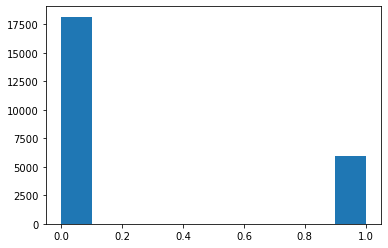

In [64]:
plt.hist(y_train)

We can see that the dataset is imbalanced, with the majority of people earning less than $50k (class label of 0). We should consider different options during modeling to account for this imbalance.

# Modeling
In this case I'm just going to use a Random Forest, since the main goal of the course is deploying the workflow and models rather than the modeling itself. Alternative models such as linear regression, AdaBoost and neural networks could also be tried.

## Base random forest
Let's see what we get using a Random Forest with just default settings.

In [105]:
rf = RandomForestClassifier()

Here we will use stratified K-fold cross-validation with five splits.

In [106]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=155)

In the starter code they provide us with some metrics to use. This includes the fbeta_score, but they use a beta value of one which is equivalent to the F1 score, so I'm not sure why they didn't use the F1 metric directly.

In [107]:
fone_scorer = make_scorer(fbeta_score, beta=1, zero_division=1)

In [108]:
scores = cross_val_score(rf, 
    X_train, 
    y_train, 
    scoring=fone_scorer, 
    cv=cv, 
    n_jobs=-1)

This outputs the F1 score for the validation data on each split.

In [109]:
scores

array([0.67068087, 0.68623025, 0.67251732, 0.68372943, 0.67645709])

The average of these scores is:

In [110]:
scores.mean()

0.6779229927555018

## Random forest with class weighting
Here we will modify the Random Forest to change the weight that each class has when computing the impurity score at each split point. As we saw above, the binary classifiction problem is imbalanced, which can result in the model being biased towards the dominant class. Here we will use a weighted Random Forest to see if this can help. We can do this by setting the `class_weight` argument in the Random Forest classifier. If we pass `balanced` it will automatically compute the weighting for us (based on number of samples in each class for the entire training dataset) so that more weight is given to the minority class.

In [ ]:
rf = RandomForestClassifier(class_weight='balanced')

In [101]:
scores = cross_val_score(rf, 
    X_train, 
    y_train, 
    scoring=fone_scorer, 
    cv=cv, 
    n_jobs=-1)

In [102]:
scores

array([0.66852886, 0.68517689, 0.67712177, 0.69325997, 0.69325997])

In [103]:
scores.mean()

0.6834694944660228

This had a very minor effect on the average score (67.7% to 68.3%). 

## Random Forest: Bootstrap class weighting
In the previous example we applied class weights based on the entire training set. However, each decision tree in the forest is constructed from a bootstrap sample, so the class distribution may be different for each tree. Scikit-learn also gives us the option to weight the scores based on class distributions in each bootstrap sample. This can be done by using the `balanced_subsample` option to the `class_weight` argument.

In [111]:
rf = RandomForestClassifier(class_weight='balanced_subsample')

In [112]:
scores = cross_val_score(rf, 
    X_train, 
    y_train, 
    scoring=fone_scorer, 
    cv=cv, 
    n_jobs=-1)

In [113]:
scores.mean()

0.6730859815666497

This resulted in a small decrease in the average cross validation score.

## Random Forest: Random undersampling
Another option is to do data resampling so that we change the class distribution to be even during bootstrapping. For this, we can use the `BalancedRandomForestClassifier` from the `imbalanced-learn` package which will perform random undersampling of the majority class.

In [115]:
rf = BalancedRandomForestClassifier()

In [116]:
scores = cross_val_score(rf, 
    X_train, 
    y_train, 
    scoring=fone_scorer, 
    cv=cv, 
    n_jobs=-1)

In [117]:
scores.mean()

0.6915322956151566

Here we see a small uplift in the scores to 0.69.

## Random forest: random search
### Balanced Random Forest
Now we will perform a random hyperparameter search to try to find a better set of hyperparameters. Here we will use the Balanced Random Forest classifier.

First we need to define the range of the hyperparameters to search over.

In [19]:
# Number of tress in random forest
n_estimators = [int(x) for x in np.linspace(20,1000,50)]
# Number of features to consider at every split
max_features = [0.5,'sqrt','log2', None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2,50,25)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2,5,10,25,100]
# Minimum number of samples at each leaf node
min_samples_leaf = [1,2,4,10,25,50,100]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [118]:
# Create random search grid
random_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

In [119]:
rf = BalancedRandomForestClassifier()

In [121]:
rf_random = RandomizedSearchCV(
    estimator=rf,
    scoring=fone_scorer,
    param_distributions=random_grid,
    n_iter=500, 
    cv=5,
    verbose=2, 
    random_state=config.models.random_seed,
    n_jobs=-1)

Now we are ready to run the search. In this case to save time I'm only running 500 trials (500 different hyperparameter combinations). A grid search would cover all possible combinaions but would also take a lot longer to run.

In [122]:
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV] END bootstrap=True, max_depth=24, max_features=log2, min_samples_leaf=100, min_samples_split=5, n_estimators=440; total time=  12.4s
[CV] END bootstrap=True, max_depth=24, max_features=log2, min_samples_leaf=100, min_samples_split=5, n_estimators=440; total time=  12.5s
[CV] END bootstrap=True, max_depth=24, max_features=log2, min_samples_leaf=100, min_samples_split=5, n_estimators=440; total time=  14.2s
[CV] END bootstrap=True, max_depth=24, max_features=log2, min_samples_leaf=100, min_samples_split=5, n_estimators=440; total time=  18.4s
[CV] END bootstrap=True, max_depth=24, max_features=log2, min_samples_leaf=100, min_samples_split=5, n_estimators=440; total time=  18.3s
[CV] END bootstrap=False, max_depth=36, max_features=None, min_samples_leaf=50, min_samples_split=5, n_estimators=560; total time= 1.6min
[CV] END bootstrap=False, max_depth=28, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estima

/home/robsmith155/miniconda3/envs/mldevops-proj3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=36, max_features=None, min_samples_leaf=50, min_samples_split=5, n_estimators=560; total time= 1.8min
[CV] END bootstrap=False, max_depth=36, max_features=None, min_samples_leaf=50, min_samples_split=5, n_estimators=560; total time= 1.8min
[CV] END bootstrap=False, max_depth=36, max_features=None, min_samples_leaf=50, min_samples_split=5, n_estimators=560; total time= 2.3min
[CV] END bootstrap=False, max_depth=36, max_features=None, min_samples_leaf=50, min_samples_split=5, n_estimators=560; total time= 2.4min
[CV] END bootstrap=False, max_depth=28, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=  58.5s
[CV] END bootstrap=True, max_depth=26, max_features=0.5, min_samples_leaf=2, min_samples_split=2, n_estimators=540; total time=  53.7s
[CV] END bootstrap=True, max_depth=26, max_features=0.5, min_samples_leaf=2, min_samples_split=2, n_estimators=540; total time=  57.2s
[CV] END bootstrap=False, max_depth=22, 

RandomizedSearchCV(cv=5, estimator=BalancedRandomForestClassifier(), n_iter=500,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 4, 6, 8, 10, 12, 14,
                                                      16, 18, 20, 22, 24, 26,
                                                      28, 30, 32, 34, 36, 38,
                                                      40, 42, 44, 46, 48, 50,
                                                      None],
                                        'max_features': [0.5, 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [1, 2, 4, 10, 25,
                                                             50, 100],
                                        'min_samples_split': [2, 5, 10, 25,
                                                              100],
             

### Random search analysis
Now let's analyse the results of the search. First off let's see how the mean score (measured by the F-beta score) varied for the different trials:

Text(0, 0.5, 'Mean F-beta score')

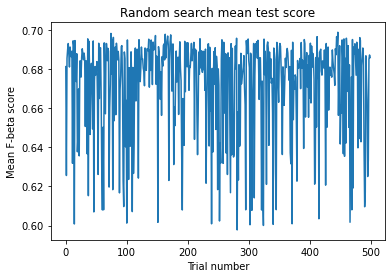

In [123]:
plt.plot(rf_random.cv_results_['mean_test_score'])
plt.title('Random search mean test score')
plt.xlabel('Trial number')
plt.ylabel('Mean F-beta score')

The best score recorded was:

In [124]:
rf_random.best_score_

0.69878148236443

This was produced by the following set of hyperparameters:

In [125]:
rf_random.best_params_

{'n_estimators': 140,
 'min_samples_split': 25,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 42,
 'bootstrap': False}

The result is only a little bit better than just using the default values. Perhaps we should try using an alternative model, but I will stick with the Random Forest for now. We could also analyze the feature importance and drop features that don't contribute to the scores.

Now let's take a look at the effct of different hyperparameters on the scores to see if their are any obvious patterns.

In [126]:
def plot_hyparams_scores(random_search, hyparam_name, hyparam_label):
    mean_score = random_search.cv_results_['mean_test_score']
    result = random_search.cv_results_['param_' + hyparam_name].data
    plt.plot(result, mean_score, 'o')
    plt.xlabel(hyparam_label)
    plt.ylabel('Mean test F-beta score')

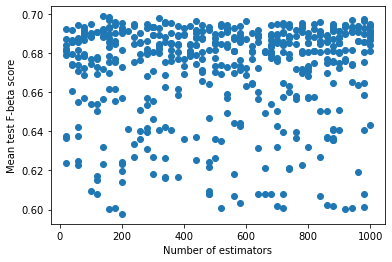

In [127]:
plot_hyparams_scores(rf_random, 'n_estimators', 'Number of estimators')

The number of estimators (number of tree's) doesn't have much impact on the results.

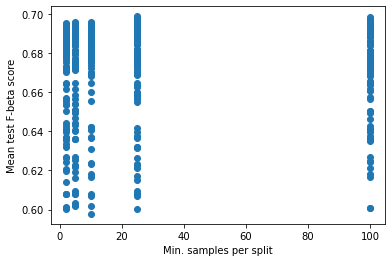

In [128]:
plot_hyparams_scores(rf_random, 'min_samples_split', 'Min. samples per split')

Here we can see that the best results comes vfrom models which use either 50 or 100 samples at each split.

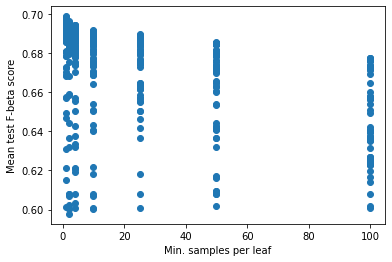

In [129]:
plot_hyparams_scores(rf_random, 'min_samples_leaf', 'Min. samples per leaf')

This shows a clear reduction in the model score with increasing samples per leaf.

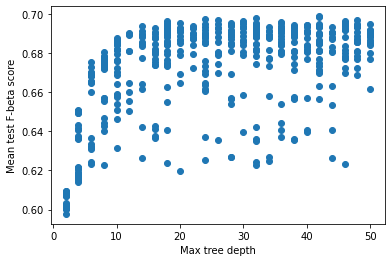

In [130]:
plot_hyparams_scores(rf_random, 'max_depth', 'Max tree depth')

Clear trend here where the model score improves ithe maximum tree depth, up to a depth of around 20.